### Notebook to assess lagged changes in precip category in TC output, binned according to a 2D variable.

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
12/18/23

### Main settings

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from thermo_functions import *
from precip_class import *
from read_functions import *
from scipy import stats
import pickle
import seaborn as sns

In [2]:
# Number of time steps to sample
t1_test=48 # max of 48
# t1_test=12 # max of 48

storm = 'haiyan'
# storm = 'maria'

# Write out pickle file?
do_write=True
do_write=False

# main = "../tc_postproc/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"+storm+'/'
# figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'
main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'

# pclass_names = ['noncloud','deepc','congest','shallowc','strat','anvil']
pclass_names=["Non-cloud", "Deep", "Cong", "Shallow", "Strat", "Anvil"]
npclass=len(pclass_names)

# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h','STRATANVIL_ON','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','NCRF','CONVOFF','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']
ntest=len(tests_str)

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 2

In [3]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
# nt_data, nz, nx1, nx2 = get_file_dims(datdir)
nx1-=80*2
nx2-=80*2

### Main read loop

In [4]:
# Main read loops for 3D (dependent) variables

nt=t1_test
npts = nx1*nx2

# Arrays to save variables
dims = (ntest, nmem, nt, nx1, nx2)
pclass_all = np.zeros(dims)
dims_area = (ntest, nmem, nt, npclass)
pclass_area = np.zeros(dims_area)

for itest in range(ntest):

    test_str=tests_str[itest]
    test_read=tests[itest]
    print('Running test: ',test_str)

    if test_read == 'ctl':
        t0=36
        # t1=t0+49
        # Control test time sample
        t1=t0+t1_test
    else:
        t0=0
        # t1=49 # max
        # Control test time sample
        t1=t1_test

    # Loop over ensemble members

    for imemb in range(nmem):

        datdir = main+memb_all[imemb]+'/'+test_read+'/'+datdir2
        pickle_file = main_pickle+memb_all[imemb]+'/pclass_'+test_read+'_'+str(t1_test)+'hrs.pkl'

        if do_write:

            # PCLASS index
            q_int = read_qcloud(datdir, t0, t1, mask=True, drop=True) # mm
            pclass_all[itest,imemb,:,:,:] = precip_class(q_int)

            for it in range(nt):
                for ipclass in range(npclass):
                    indices = (pclass_all[itest,imemb,it,...] == ipclass).nonzero()
                    pclass_area[itest,imemb,it,ipclass] = indices[0].shape[0]/npts

            with open(pickle_file, 'wb') as file:
                pickle.dump([pclass_all[itest,imemb,...], pclass_area[itest,imemb,...]], file)

        else:

            with open(pickle_file, 'rb') as file:
                ipclass, ipclass_area = pickle.load(file)
            pclass_all[itest,imemb,...]  = ipclass
            pclass_area[itest,imemb,...] = ipclass_area

Running test:  CTL
Running test:  NCRF
Running test:  CONVOFF
Running test:  STRATANVOFF
Running test:  STRATOFF


### P-Class DDT

In [5]:
nddt=6 # n-time steps to diagnose lead changes
dims_ddt = (ntest, nmem, nt-nddt, nddt, npclass, npclass)
pclass_ddt = np.zeros(dims_ddt)

for itest in range(ntest):
    for imemb in range(nmem):

        for it_init in range(nt-nddt):

            ivar_init = pclass_all[itest,imemb,it_init,...]

            for ipclass_init in range(npclass):
                indices_init = (ivar_init == ipclass_init).nonzero()
                for it_new in range(nddt):
                    ivar_new = pclass_all[itest,imemb,it_init+it_new,...]
                    ivar_new_indexed = ivar_new[indices_init]
                    for ipclass_new in range(npclass):
                        indices_new = (ivar_new_indexed == ipclass_new).nonzero()
                        pclass_ddt[itest,imemb,it_init,it_new,ipclass_init,ipclass_new] = indices_new[0].shape[0]

---
### Plotting routines

#### Plotting functions

In [6]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [7]:
# Confidence interval using T-test and assuming 95% significance
def mean_confidence_interval(data):
    # conf_set=0.95 # Confidence interval to apply throughout
    conf_set=0.9 # Confidence interval to apply throughout
    a = 1.0 * np.array(data)
    # n = len(a)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    # num = stats.t.ppf((1 + conf_set) / 2., n-1)
    h = se * stats.t.ppf((1 + conf_set) / 2., n-1)
    return m, m-h, m+h

In [8]:
# Smooth time series
# Assumes f = f(nmem, nt), smooths only over 2nd dimension
def smooth_tser(invar):
    invar_sm = np.copy(invar)
    invar_sm[:,1:-1] = (invar_sm[:,2:] + invar_sm[:,1:-1] + invar_sm[:,0:-2])/3
    return invar_sm

#### P-Class area time series

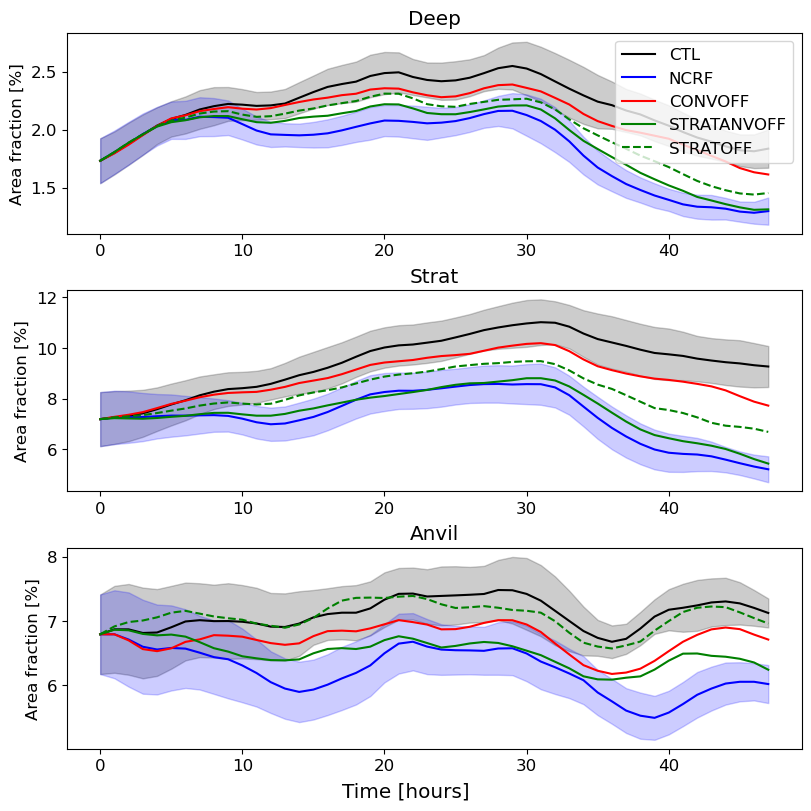

In [44]:
xmax=nt
# xmax=12

# Plot as difference from CTL?
i_ctldiff=True
i_ctldiff=False

# Standardize?
i_standardize=True
i_standardize=False

# XX Average ensemble members
# pltvar = np.mean(pclass_area, axis=1)
pltvar = np.copy(pclass_area)

# As difference from CTL-ens-mean
ctl=np.mean(pltvar[0], axis=0)
pltvar_anom = pltvar*1e2
if i_ctldiff:
        pltvar_anom -= ctl[np.newaxis,np.newaxis,...]

ylabel='Area fraction [%]'
if i_standardize:
        # XX Normalize by mean for each pclass
        # Standardize using STD from all pclass, ensemble members
        stddev = np.std(pltvar,axis=(0,1,2))
        stddev_ctl = np.std(pltvar[0],axis=(0,1))
        # pltvar_anom = pltvar_anom/stddev[np.newaxis,np.newaxis,np.newaxis,:]
        pltvar_anom = pltvar_anom/stddev_ctl[np.newaxis,np.newaxis,np.newaxis,:]
        ylabel='Standardized\nDifference from CTL'

linecolor=['black', 'blue', 'red', 'green', 'green']
linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
linestyle[-1]='dashed'

# create figure

# ipclass_plot=np.arange(npclass)
# ipclass_plot=[1,2,3,4,5]
ipclass_plot=[1,4,5]
npclass_plot=len(ipclass_plot)

fig_x = 8
# fig_y = 14
fig_y = 8
fig, ax = plt.subplots(npclass_plot,1, figsize=(fig_x,fig_y), layout="constrained",) # row, column

fig.supxlabel('Time [hours]')

for ipclass in range(npclass_plot):

        ipclass_data=ipclass_plot[ipclass]

        # create figure
        # fig = plt.figure(figsize=(14,4))
        # ax = fig.add_subplot(111)

        fig_title = pclass_names[ipclass_data]
        ax[ipclass].set_title(fig_title)

        for itest in range(ntest):
                ipvar=pltvar_anom[itest,:,:,ipclass_data]
                ipvar_sm = smooth_tser(ipvar)
                # ipvar_sm = np.copy(ipvar)
                mean, low, high = mean_confidence_interval(ipvar_sm)
                ax[ipclass].plot(mean[:xmax], label=tests_str[itest],
                         color=linecolor[itest], linestyle=linestyle[itest])
                if itest <= 1:
                        ax[ipclass].fill_between(np.arange(xmax), high[:xmax], low[:xmax], alpha=0.2, color=linecolor[itest])
                # ax[ipclass].set_ylim(-3,1)

        ax[ipclass].set_ylabel(ylabel)

# if ipclass == 0:
ax[0].legend()#loc="lower left")

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

#### Area ratio

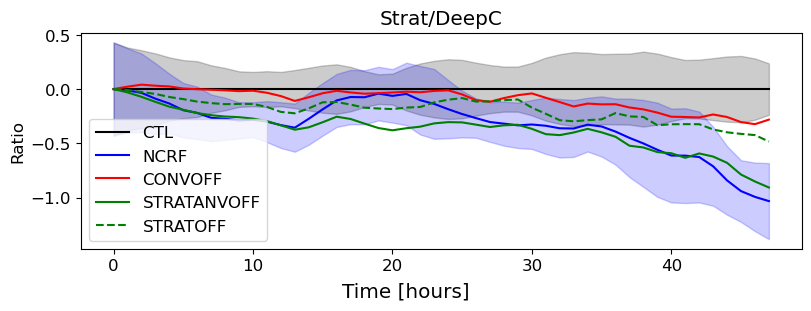

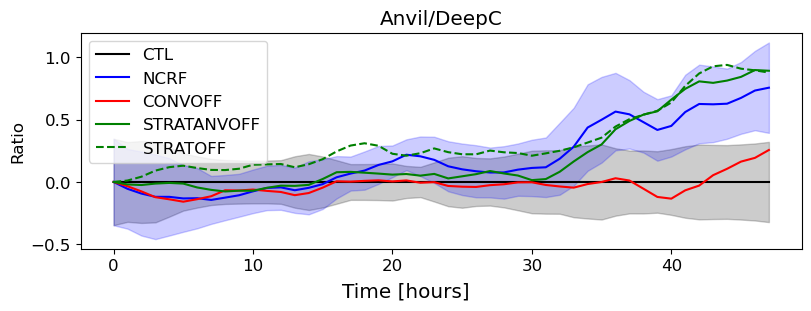

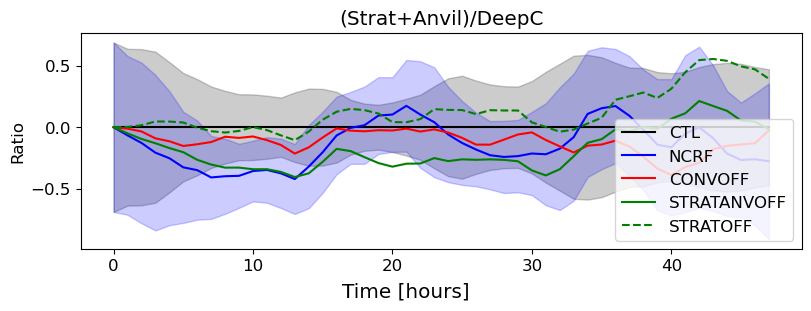

In [48]:
xmax=nt
# xmax=12

# Plot as difference from CTL?
i_ctldiff=True
# i_ctldiff=False

# Standardize?
i_standardize=True
i_standardize=False

for iratio in range(3):

        if iratio == 0:
                fig_title = 'Strat/DeepC'
                pltvar = pclass_area[:,:,:,4]/pclass_area[:,:,:,1] # Strat / Conv
        elif iratio == 1:
                fig_title = 'Anvil/DeepC'
                pltvar = pclass_area[:,:,:,5]/pclass_area[:,:,:,1] # Anvil / Conv
        elif iratio == 2:
                fig_title = '(Strat+Anvil)/DeepC'
                pltvar = (pclass_area[:,:,:,4] + pclass_area[:,:,:,5])/pclass_area[:,:,:,1] # Strat+Anvil / Conv

        # As difference from CTL-ens-mean
        ctl=np.mean(pltvar[0], axis=0)
        pltvar_anom = pltvar
        if i_ctldiff:
                pltvar_anom -= ctl[np.newaxis,np.newaxis,...]

        ylabel='Ratio'
        if i_standardize:
                # XX Normalize by mean for each pclass
                # Standardize using STD from all ensemble members
                stddev = np.std(pltvar,axis=(0,1))
                stddev_ctl = np.std(pltvar[0],axis=0)
                # pltvar_anom = pltvar_anom/stddev[np.newaxis,np.newaxis,np.newaxis,:]
                pltvar_anom = pltvar_anom/stddev_ctl[np.newaxis,np.newaxis,:]
                ylabel='Standardized\nDifference from CTL'

        linecolor=['black', 'blue', 'red', 'green', 'green']
        linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
        linestyle[-1]='dashed'

        # create figure

        # ipclass_plot=np.arange(npclass)
        # ipclass_plot=[1,2,3,4,5]
        ipclass_plot=[1,4,5]
        npclass_plot=len(ipclass_plot)

        fig_x = 8
        # fig_y = 14
        fig_y = 3
        fig, ax = plt.subplots(1,1, figsize=(fig_x,fig_y), layout="constrained",) # row, column

        fig.supxlabel('Time [hours]')

        # create figure
        # fig = plt.figure(figsize=(14,4))
        # ax = fig.add_subplot(111)

        ax.set_title(fig_title)

        for itest in range(ntest):
                ipvar=pltvar_anom[itest,:,:]
                ipvar_sm = smooth_tser(ipvar)
                # ipvar_sm = np.copy(ipvar)
                mean, low, high = mean_confidence_interval(ipvar_sm)
                ax.plot(mean[:xmax], label=tests_str[itest],
                                color=linecolor[itest], linestyle=linestyle[itest])
                if itest <= 1:
                        ax.fill_between(np.arange(xmax), high[:xmax], low[:xmax], alpha=0.2, color=linecolor[itest])
        # ax.set_ylim(-3,1)

        ax.set_ylabel(ylabel)

        # if ipclass == 0:
        ax.legend()#loc="lower left")

        #     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #                 bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

#### P-Class DDT box plots

In [ ]:
def create_boxplot_noclear(invar, title_tag, fig_tag, units, yscale='linear'):

    # c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    c_name = ['Deep\nConvective', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
    cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(5.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    # sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    sns.boxplot([invar[1], invar[2], invar[3], invar[4], invar[5]],
                width=0.7, showmeans=True, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})

    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.7)
    ax.set_yscale(yscale)
    ax.set_xticklabels(c_name)
    plt.ylabel(units)
    plt.title(title_tag)
    time_tag='_'+str(nt)+'hrs'
    # time_tag=''
    plt.show()
    # plt.savefig(figdir+fig_tag+'_'+test_str+time_tag+'.png',dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)
    plt.close()

In [ ]:
def create_boxplot_testcomp(invar, tests_str, title_tag, fig_tag, units, yscale='linear'):

    # c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    c_name = tests_str
    cmap = ['teal', 'plum', 'darkorange', 'gold']#, 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(4.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    # sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    sns.boxplot([invar[0], invar[1], invar[2], invar[3]],#, invar[4]],
                width=0.7, showmeans=True, showfliers=False, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})

    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.7)
    ax.set_yscale(yscale)
    # ax.set_ylim([-10,10])
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    # plt.title("Class-averaged "+title_tag)#, weight='bold')
    plt.title(title_tag)#, weight='bold')
    time_tag='_'+str(nt)+'hrs'
    # time_tag=''
    plt.show()
    # plt.savefig(figdir+fig_tag+'_'+test_str+time_tag+'.png',dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)
    plt.close()

(6, 10)


/tmp/ipykernel_34312/252004905.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


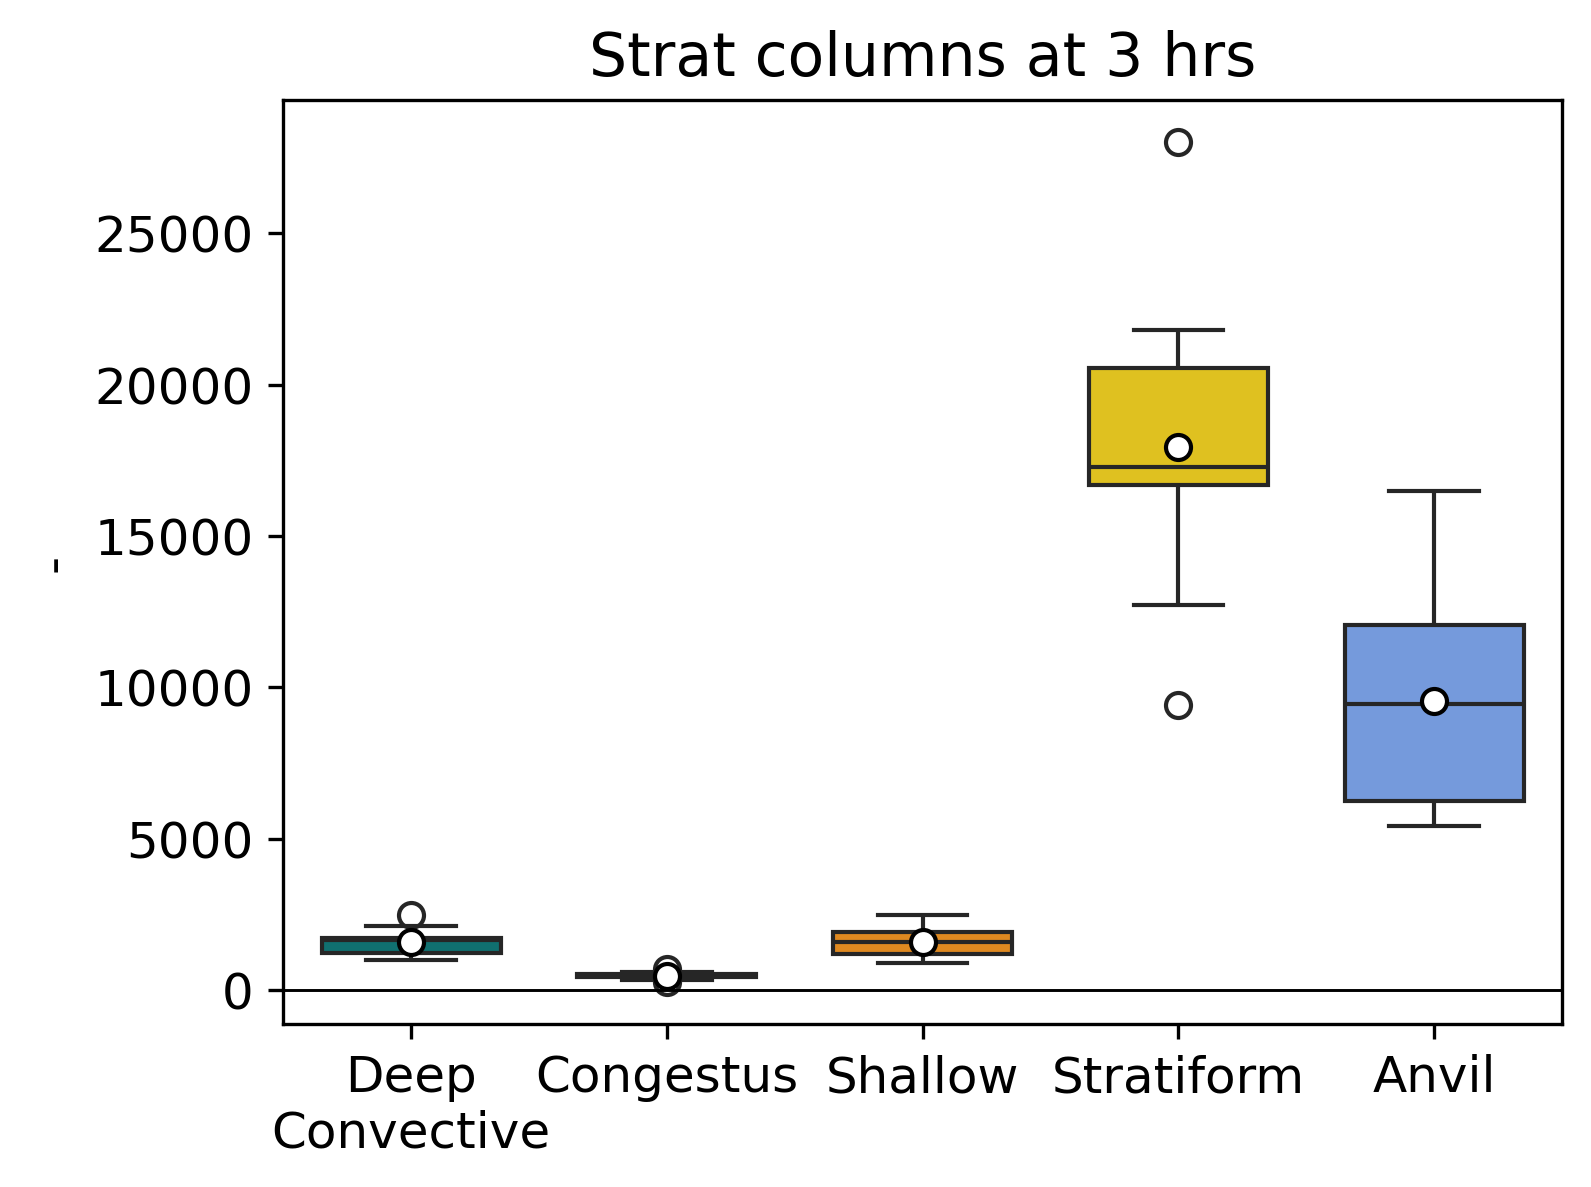

In [ ]:
# Settings
ipclass_init=4
ipclass_new=4
it_init=0
it_new=3

# for itest in range(ntest):
for itest in range(1):

    # pclass_ddt_avg = np.mean(pclass_ddt, axis=1)
    pltvar = np.transpose(pclass_ddt[itest,:,it_init,it_new,ipclass_init,:])
    # pltvar = np.transpose(pclass_ddt[itest,:,it_init,1:,ipclass_init,:])
    print(np.shape(pltvar))

    # units = "mm/d"
    units = "-"
    title_tag = pclass_names[ipclass_init]+" columns at "+str(it_new)+' hrs'
    fig_tag = pclass_names[ipclass_init]+"_"+str(it_new)
    create_boxplot_noclear(np.reshape(pltvar,(npclass,nmem)), title_tag, fig_tag, units)#, yscale="log")
    # create_boxplot_noclear(np.reshape(pltvar,(npclass,nmem*(nddt-1))), title_tag, fig_tag, units)#, yscale="log")

/tmp/ipykernel_34312/1708414320.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


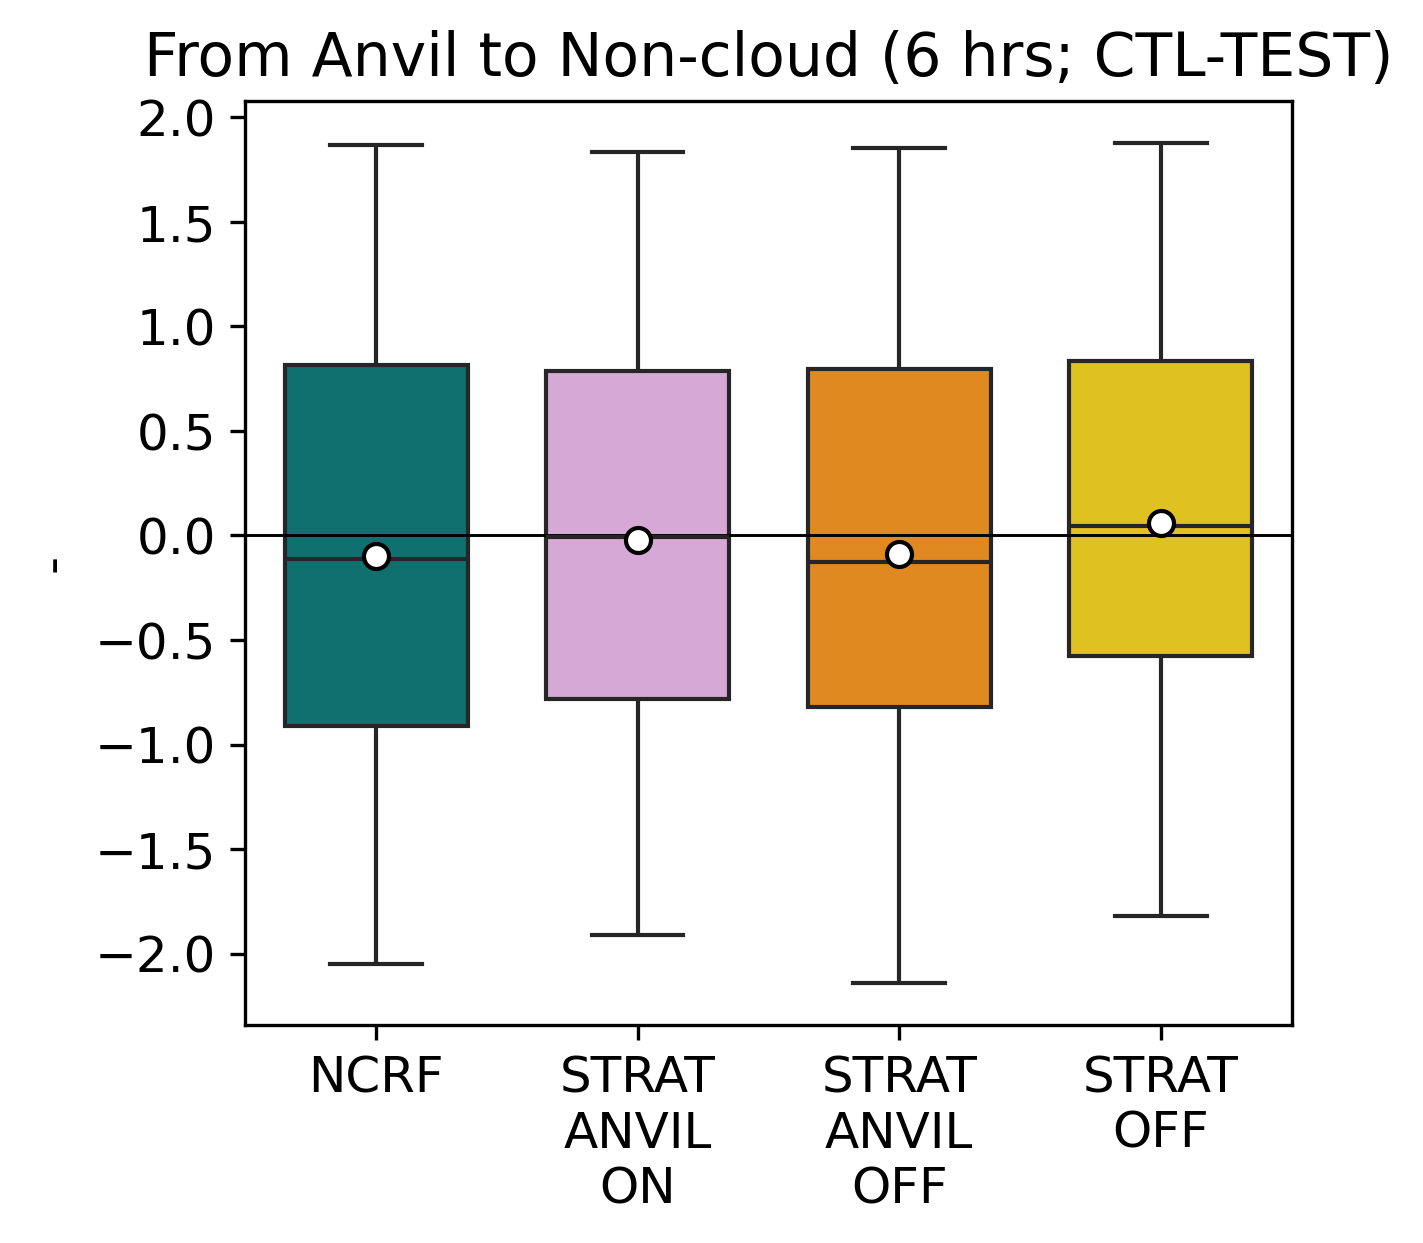

/tmp/ipykernel_34312/1708414320.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


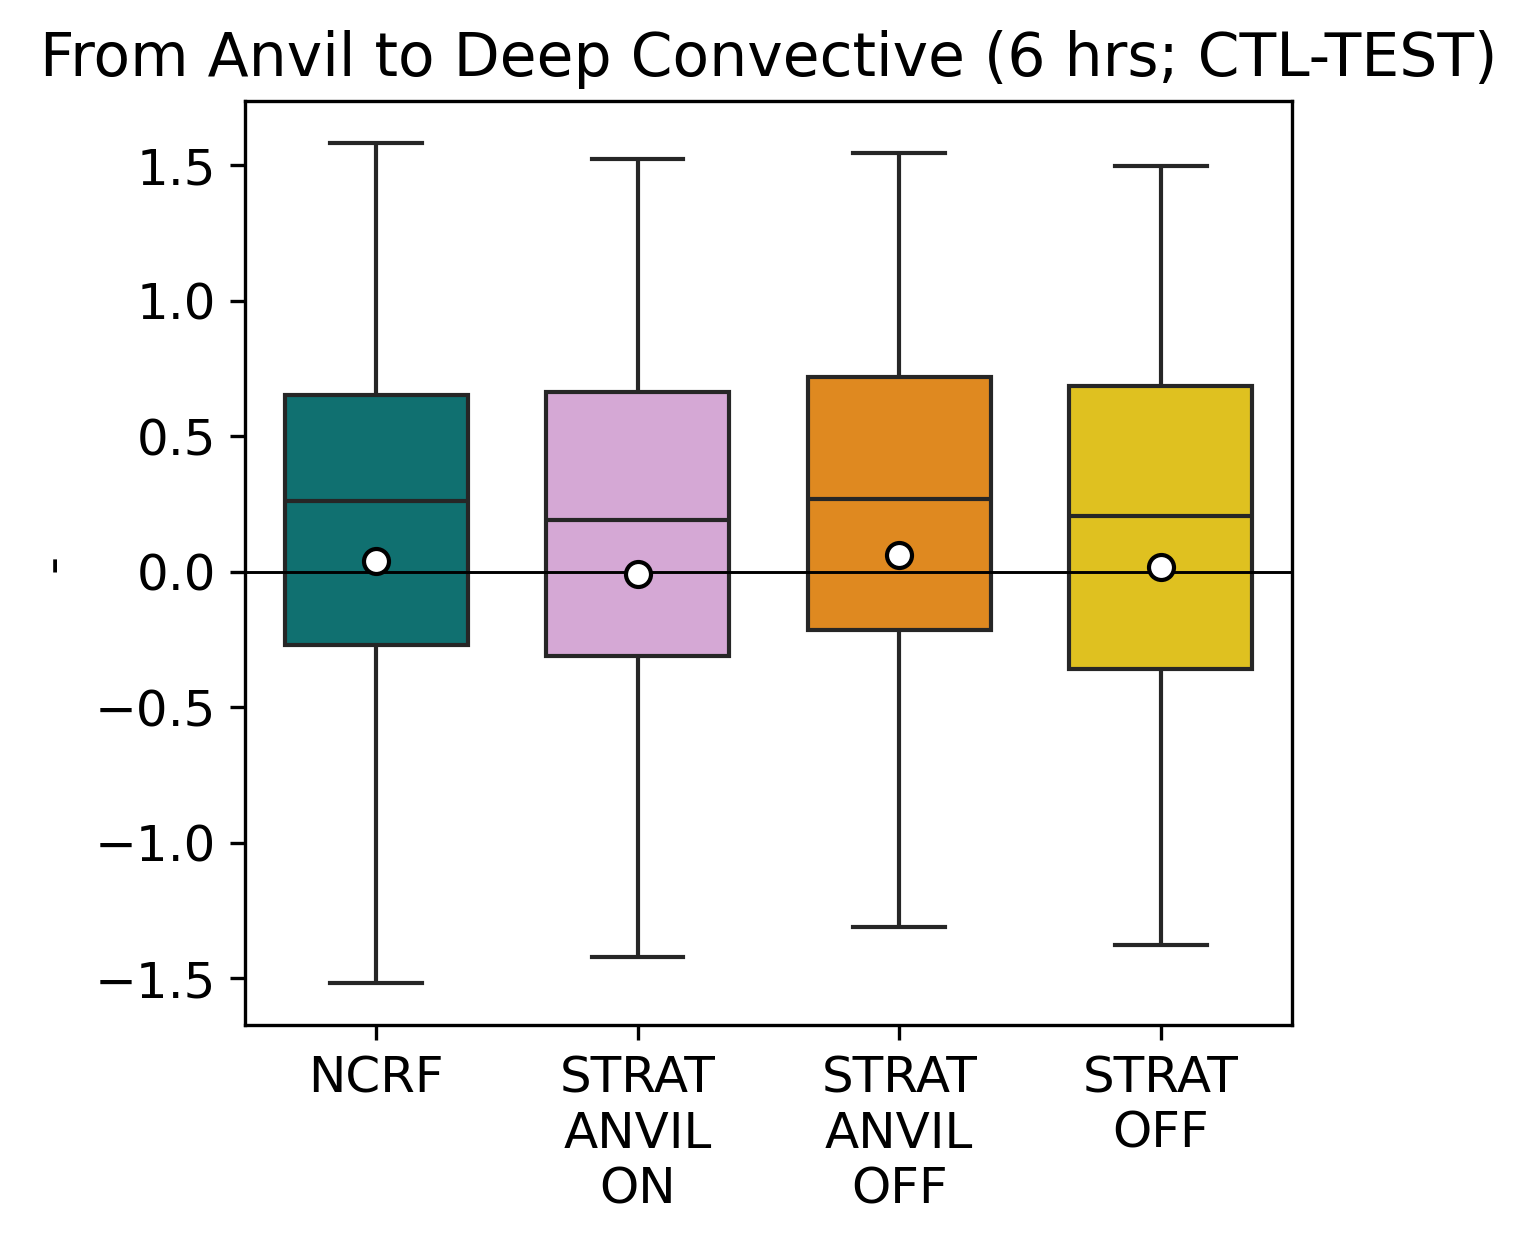

/tmp/ipykernel_34312/1708414320.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


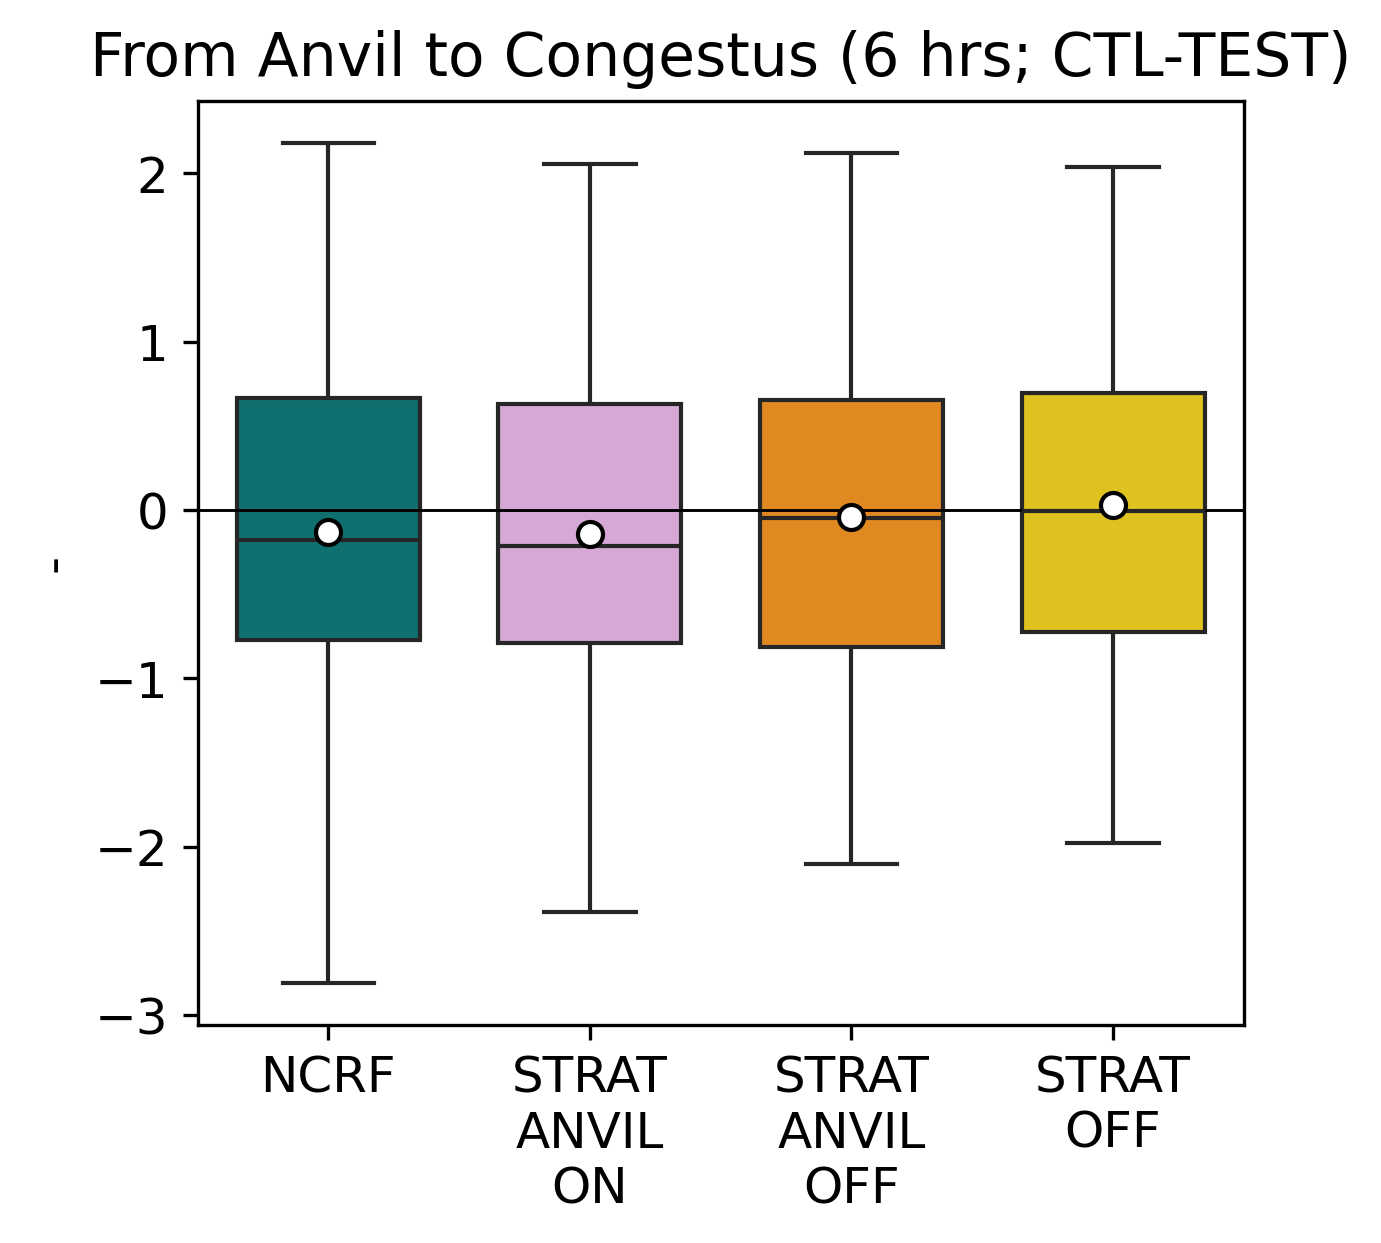

/tmp/ipykernel_34312/1708414320.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


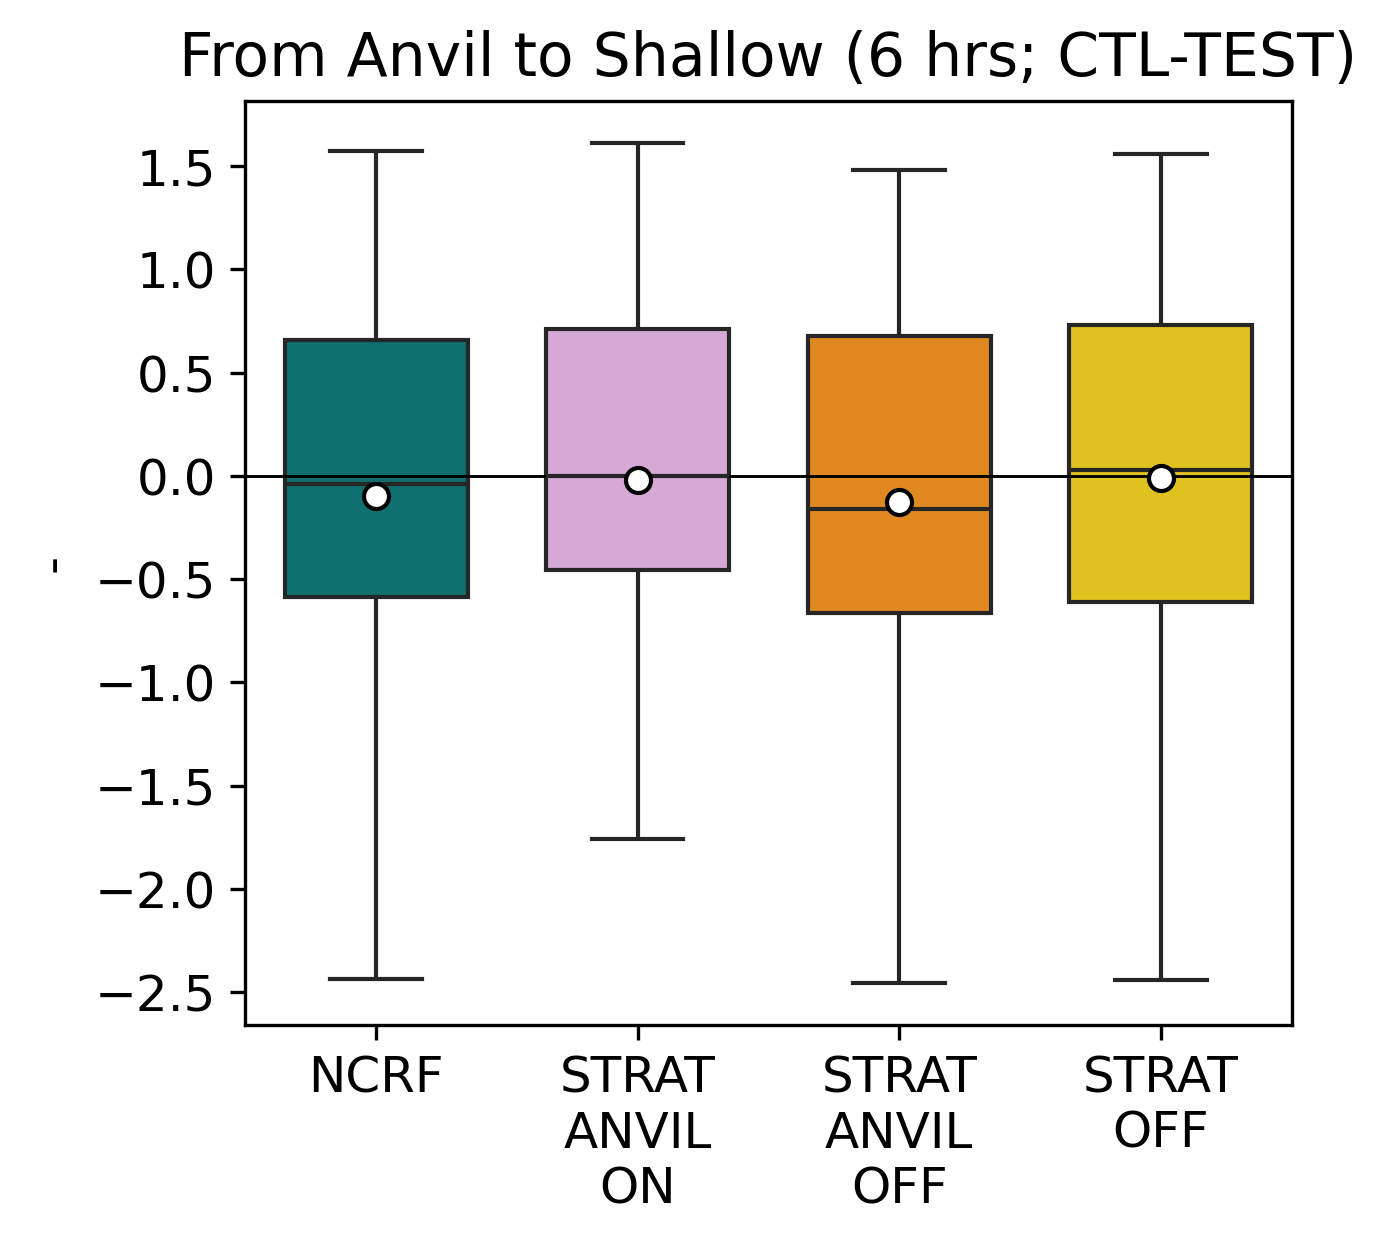

/tmp/ipykernel_34312/1708414320.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


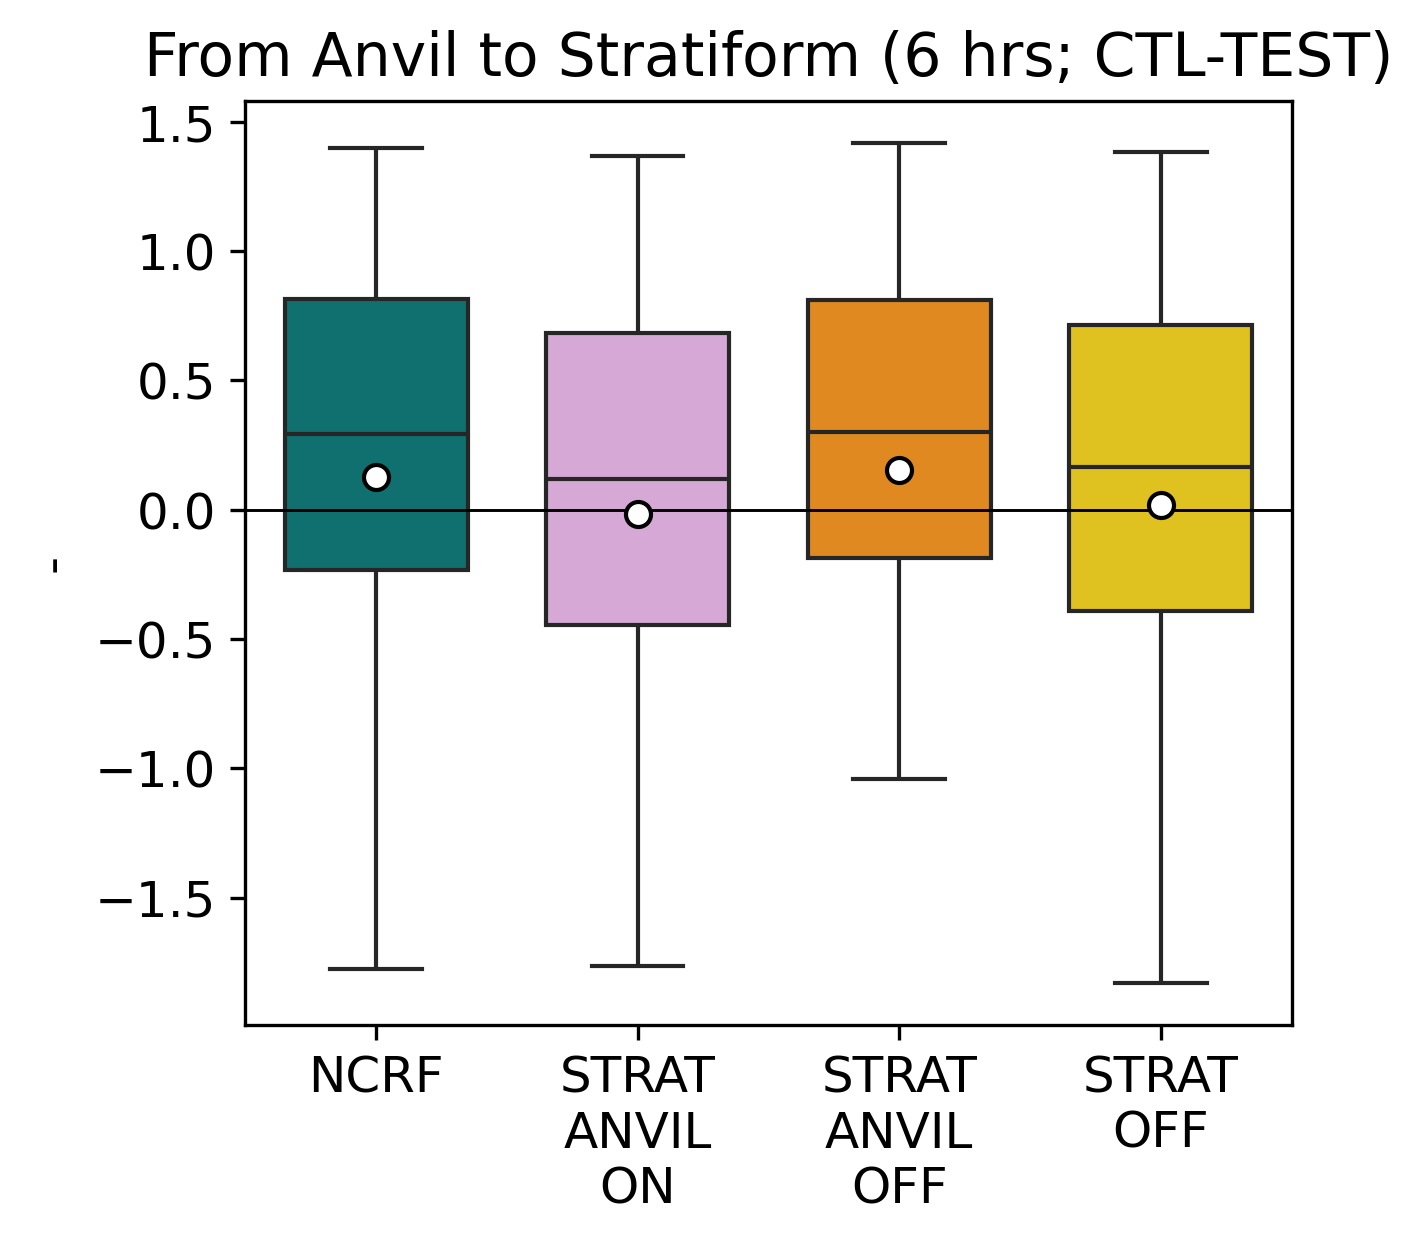

/tmp/ipykernel_34312/1708414320.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


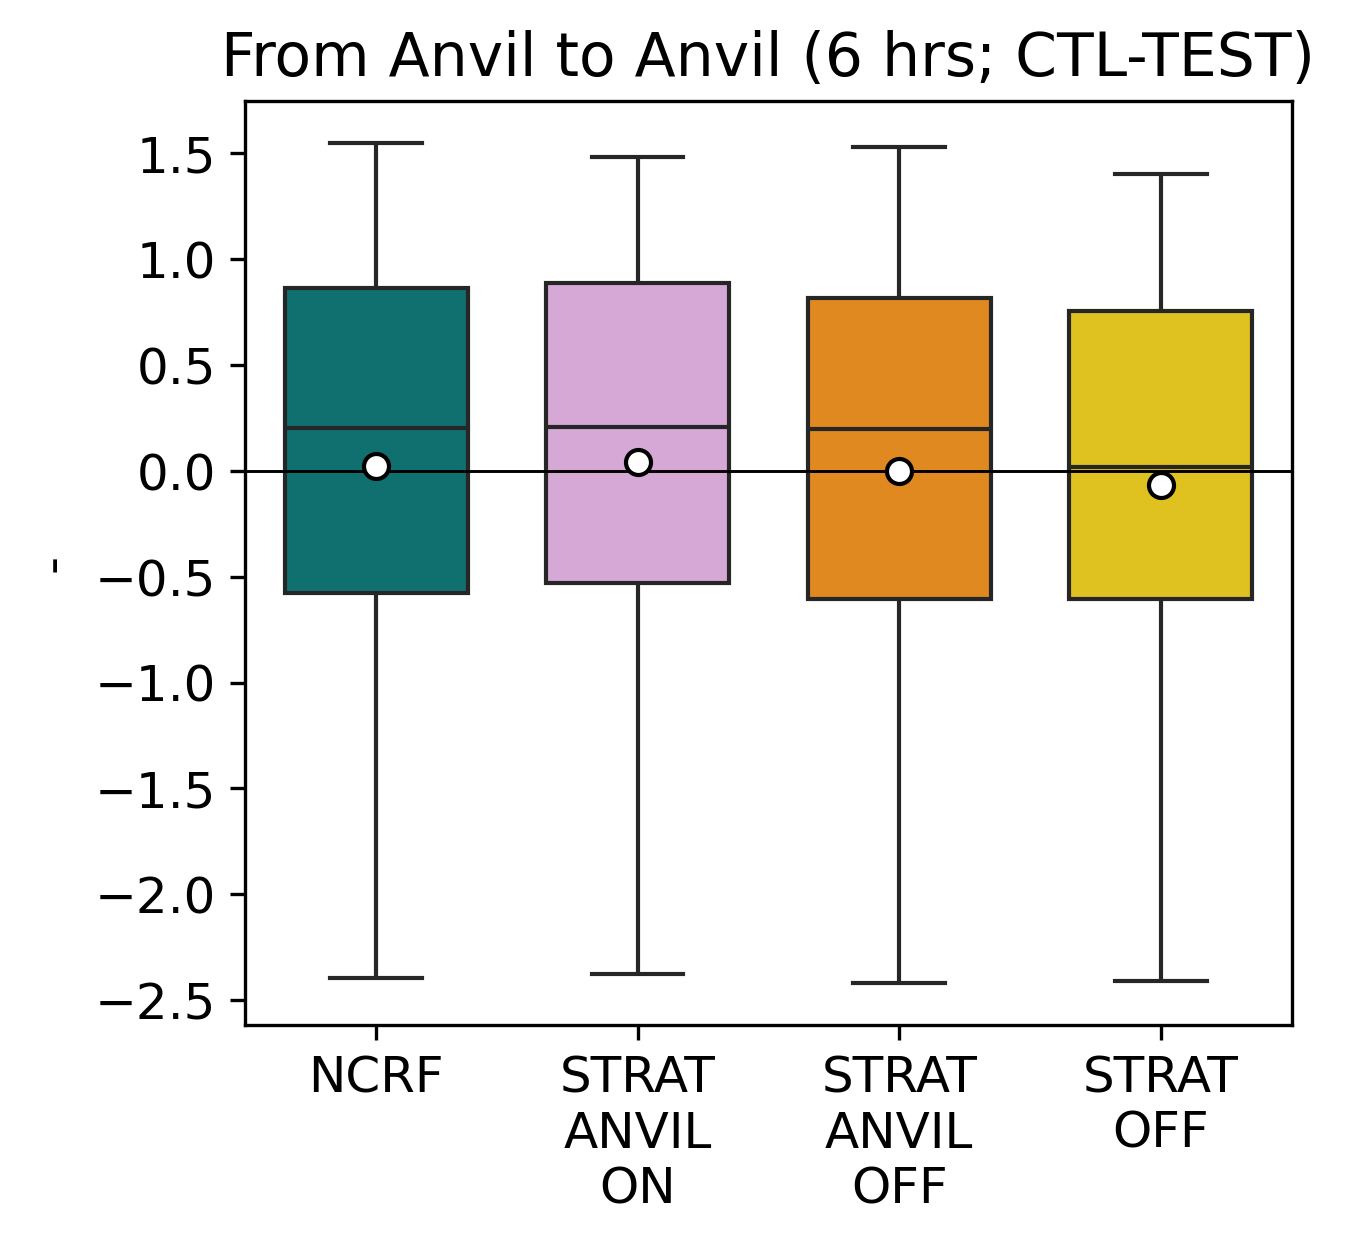

In [ ]:
# Settings
ipclass_ref=5
it_init=0
it_new=6

# pltvar = np.transpose(pclass_ddt[:,:,it_init,it_new,ipclass_ref,:], axes=(2,0,1))
pltvar = pclass_ddt[:,:,it_init,1:it_new,ipclass_ref,:]

# tests_str2 = ['CTL','NCRF','STRAT\nANVIL\nON','STRAT\nANVIL\nOFF','STRAT\nOFF']
tests_str2 = ['NCRF','STRAT\nANVIL\nON','STRAT\nANVIL\nOFF','STRAT\nOFF']

c_name = ['Non-cloud', 'Deep Convective', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
c_name2 = ['nonp', 'deepc', 'cong', 'shall', 'strat', 'anvil']


ctl_ref = pltvar[0]
ctl_ensmn = np.mean(ctl_ref, axis=(0,1))
# ctl_sddev = np.std(ctl_ref,axis=(1,2))
sddev = np.std(pltvar,axis=(0,1,2))

for ipclass in range(npclass):
# for ipclass in range(4,npclass):

    # invar = (pltvar[1:,:,ipclass] - ctl_ensmn[ipclass]) / sddev[ipclass]
    invar = (ctl_ensmn[ipclass] - pltvar[1:,:,:,ipclass]) / sddev[ipclass]
    # sddev = np.std(rawvar[ipclass,1:],axis=(1,2))[:,np.newaxis,np.newaxis]
    # invar = (rawvar[ipclass,1:] - ctl_mn[ipclass]) / sddev
    invar_reshaped = np.reshape(invar,(ntest-1,nmem*(it_new-1)))
    # invar_reshaped = invar

    units = "-"
    # title_tag = pclass_names[ipclass_ref]+" columns at "+str(it_new)+' hrs'
    # title_tag = 'From '+c_name[ipclass_ref]+' to '+c_name[ipclass]+' ('+str(it_new)+' hrs; TEST-CTL)'
    title_tag = 'From '+c_name[ipclass_ref]+' to '+c_name[ipclass]+' ('+str(it_new)+' hrs; CTL-TEST)'
    fig_tag = pclass_names[ipclass_ref]+"_"+str(it_new)
    # create_boxplot_testcomp(var_ctl[np.newaxis,...] - invar, tests_str2, title_tag, fig_tag, units, yscale="linear")
    # create_boxplot_testcomp(mn - invar, tests_str2, title_tag, fig_tag, units, yscale="linear")
    create_boxplot_testcomp(invar_reshaped, tests_str2, title_tag, fig_tag, units, yscale="linear")